# Monte-Carlo-Dropout-Sampling

## Introduction

Monte-Carlo-Dropout-Sampling as introduced by Gal & Ghahramani in [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/abs/1506.02142v4) is a way to model uncertainty in neural networks. The main idea is to use a neural network with a pattern of dense and dropout layers with high dropout probabilities to in effect train not one, but a whole forest of networks. Kendall & Cipolla in [Modelling Uncertainty in Deep Learning for Camera Relocalization](https://arxiv.org/abs/1509.05909) describe a practical way to use this for uncertainty estimation: by activating the dropout layers during multiple forward prediction passes, in effect the data passes through different versions of networks contained in the same model and statistical values such as the mean or the standard deviation can be derived from the outputs of the different passes.

## Application

The prediction of air quality from sparse factors such as the number of cars on a road or the wind speed is difficult. Oftentimes, factors that look relevant are not and vice versa. Uncertainty prediction makes it possible for us to explain the learned space of a model and to see which combinations of input parameters cause the model to become more precise and which cause predictions to become less reliable. This of course can be very valuable, for example, we could theoretically find out that our NO2-sensor malfunctions when temperatures fall below freezing by looking at the uncertainty values over the temperature range and could then discard these rows from our dataset or replace the sensor.

## Implementation

Lets first set up tensorflow and import our dataset

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.3.0


In [2]:
data = pd.read_csv("../../datasets/all.csv")
# convert dates
data["Hour"] = data["Hour"].astype("str")
data["DateTime"] = pd.to_datetime(data["Date"] + " " + data["Hour"] + ":00:00")
del data["Hour"]
del data["Date"]
# set datetime index
data.index = pd.DatetimeIndex(data.DateTime)
# fix no2 col
data = data[data['NO2-ug-per-m3'].apply(lambda x: str(x).isnumeric())]
data["NO2-ug-per-m3"] = data["NO2-ug-per-m3"].astype("int")
# fix temp col
data = data[data["air_temp_deg_c"] > -500]
#remove school holidays
#data = data.drop(["SchoolHoliday", "Monday", "Tuesday", 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Janurary', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],axis=1)
data = data.dropna()
data.head()

,NO2-ug-per-m3,Cars-Direction-1,Cars-Direction-2,Cars-Total,Day-Of-Week,Monday,Tuesday,Wednesday,Thursday,Friday,...,wind_meters_per_second,rain_millimeters,did_it_rain,air_temp_deg_c,relative_humidity_percent,e5,e10,diesel,Number of vessels,DateTime
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 04:00:00,8,60,44,104,2,0,1,0,0,0,...,8.2,0.2,1,7.8,94.0,1.409000,1.389000,1.289000,3,2019-01-01 04:00:00
2019-01-01 05:00:00,5,44,33,77,2,0,1,0,0,0,...,9.1,0.0,1,8.1,94.0,1.412924,1.387101,1.272671,5,2019-01-01 05:00:00
2019-01-01 06:00:00,5,46,43,89,2,0,1,0,0,0,...,9.8,0.1,1,8.2,83.0,1.389000,1.365522,1.241174,4,2019-01-01 06:00:00
2019-01-01 07:00:00,5,39,41,80,2,0,1,0,0,0,...,9.9,0.0,0,7.0,75.0,1.377876,1.353382,1.229562,3,2019-01-01 07:00:00
2019-01-01 08:00:00,6,26,35,61,2,0,1,0,0,0,...,9.8,0.0,0,7.0,73.0,1.361500,1.336188,1.205406,3,2019-01-01 08:00:00


In [3]:
(data.columns, data.shape)

(Index(['NO2-ug-per-m3', 'Cars-Direction-1', 'Cars-Direction-2', 'Cars-Total',
        'Day-Of-Week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
        'Saturday', 'Sunday', 'January', 'February', 'March', 'April', 'May',
        'June', 'July', 'August', 'September', 'October', 'November',
        'December', 'SchoolHoliday', 'wind_meters_per_second',
        'rain_millimeters', 'did_it_rain', 'air_temp_deg_c',
        'relative_humidity_percent', 'e5', 'e10', 'diesel', 'Number of vessels',
        'DateTime'],
       dtype='object'),
 (6515, 35))

Lets split the data into a training and a validation set. Since DateTime as a column is already represented via the one-hot encodings, we discard it

In [4]:
training = data.sample(frac = 0.75)
validation = data.drop(training.index)

training_x = training.drop(["NO2-ug-per-m3", "DateTime"], axis=1).to_numpy(dtype=float)
training_y = training["NO2-ug-per-m3"].to_numpy(dtype=float)

validation_x = validation.drop(["NO2-ug-per-m3", "DateTime"], axis=1).to_numpy(dtype=float)
validation_y = validation["NO2-ug-per-m3"].to_numpy(dtype=float)


We can now define our model

In [5]:
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras import Model
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=(33,)))
for i in range(16):
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.1))
model.add(Dense(1, activation="relu"))

and train it for 100 epochs. The exact settings don't matter to much for our case, but we would like it to have a good grasp of the data while not being overfitted

In [6]:
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
model.fit(training_x, training_y, validation_data=(validation_x, validation_y), batch_size=16, epochs=100, verbose=0)

Our forward sampling function will work by running the same input data through the model multiple times with different dropout nodes active. We can then derive a mean and a standard deviation

In [7]:
def monte_carlo_sample(model, data, iterations=8):
    datas = []
    for i in range(iterations):
        datas.append(model(np.array([test_data]), training=True).numpy()[0])
    datas = np.array(datas)
    return (np.mean(datas), np.std(datas))

In [8]:
test_data = validation_x[0,:]

In [9]:
monte_carlo_sample(model, test_data, iterations=8)

(19.118595, 1.089471)

as you can see, for the first entry in our data, the model predicts an NO2 value of 19µg/m³ with one standard deviation being about 1.

We can now iterate through all rows of our validation dataset and evaluate the model on them. Let's focus on the predictions as well as their difference to the real data

In [10]:
rows = []
for (index, data) in validation.iterrows():
    eval_data = data.copy()
    sample_data = data.drop(["NO2-ug-per-m3", "DateTime"]).to_numpy()
    (mean, std) = monte_carlo_sample(model, sample_data)
    eval_data["predicted_no2"] = mean
    eval_data["prediction_stdev"] = std
    eval_data["delta_mean_real_no2"] = abs(data["NO2-ug-per-m3"] - mean)
    rows.append(eval_data)
evaluation = pd.DataFrame(rows)
evaluation.head()

,NO2-ug-per-m3,Cars-Direction-1,Cars-Direction-2,Cars-Total,Day-Of-Week,Monday,Tuesday,Wednesday,Thursday,Friday,...,air_temp_deg_c,relative_humidity_percent,e5,e10,diesel,Number of vessels,DateTime,predicted_no2,prediction_stdev,delta_mean_real_no2
2019-01-01 05:00:00,5,44,33,77,2,0,1,0,0,0,...,8.1,94.0,1.412924,1.387101,1.272671,5,2019-01-01 05:00:00,23.384449,2.012048,18.384449
2019-01-01 09:00:00,6,38,19,57,2,0,1,0,0,0,...,7.0,75.0,1.341857,1.316143,1.181857,5,2019-01-01 09:00:00,21.455992,1.199092,15.455992
2019-01-01 11:00:00,16,112,111,223,2,0,1,0,0,0,...,7.1,69.0,1.373608,1.346941,1.209294,4,2019-01-01 11:00:00,21.838177,1.996621,5.838177
2019-01-02 09:00:00,73,359,277,636,3,0,0,1,0,0,...,3.7,54.0,1.366204,1.340290,1.217710,6,2019-01-02 09:00:00,22.170139,2.073988,50.829861
2019-01-02 20:00:00,86,165,212,377,3,0,0,1,0,0,...,-0.2,72.0,1.274000,1.246500,1.151500,1,2019-01-02 20:00:00,22.651161,1.806367,63.348839


Dataframes are a bit hard to reason about, lets plot this

In [11]:
import matplotlib.pyplot as plt

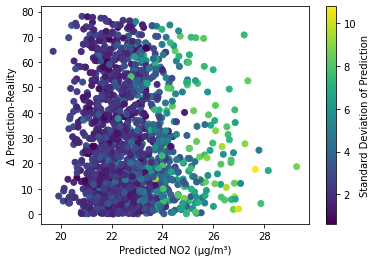

In [12]:
plt.scatter(x=evaluation["predicted_no2"], y=evaluation["delta_mean_real_no2"], c=evaluation["prediction_stdev"])
plt.xlabel("Predicted NO2 (µg/m³)")
plt.ylabel("Δ Prediction-Reality")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Standard Deviation of Prediction", rotation=90)
plt.show()

As you can see, the quality of our predictions (as shown by how yellow the dots are) drops when the predicted values are larger. At the same time, the error of the prediction doesn't seem to be obviously influenced by the predicted value.

Next, we will look at how the distribution of values in a single column influences uncertainty. This is of course by no means perfect, since correlations between columns can and probably will exist, but maybe we find something interesting.

editors note: TODO. Also the model has probably just learnt the mean of the dataset. But thats for tomorrow. Here (https://arxiv.org/abs/1808.09432v1) is a paper that applies MCDS to RNNs.

NO2-ug-per-m3
Cars-Direction-1
Cars-Direction-2
Cars-Total
Day-Of-Week
Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday
January
February
March
April
May
June
July
August
September
October
November
December
SchoolHoliday
wind_meters_per_second
rain_millimeters
did_it_rain
air_temp_deg_c
relative_humidity_percent
e5
e10
diesel
Number of vessels
DateTime
predicted_no2
prediction_stdev
delta_mean_real_no2


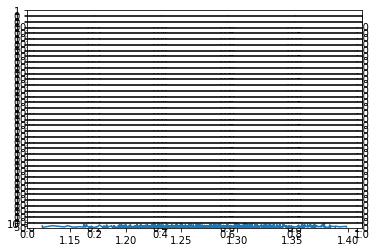

In [13]:
fig, axs = plt.subplots(nrows=len(evaluation.columns))
for col in evaluation.columns:
    print(col)
data = evaluation[["diesel", "prediction_stdev"]].sort_values(by="diesel")
plt.plot(data["diesel"], data["prediction_stdev"])